## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Calibrate and Correct for Distortion

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

./camera_cal/calibration1.jpg
./camera_cal/calibration10.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration15.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration18.jpg
./camera_cal/calibration19.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration20.jpg
./camera_cal/calibration3.jpg
./camera_cal/calibration4.jpg
./camera_cal/calibration5.jpg
./camera_cal/calibration6.jpg
./camera_cal/calibration7.jpg
./camera_cal/calibration8.jpg
./camera_cal/calibration9.jpg


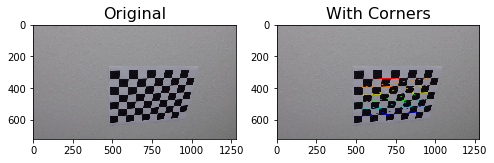

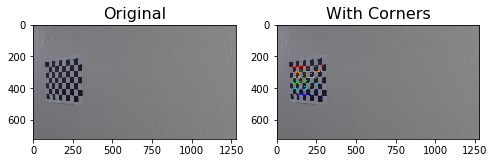

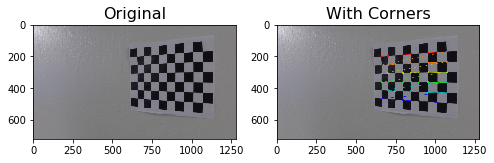

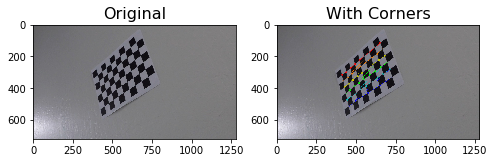

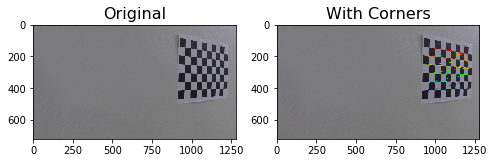

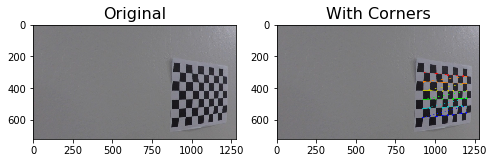

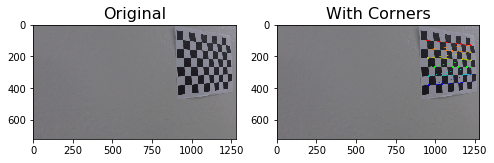

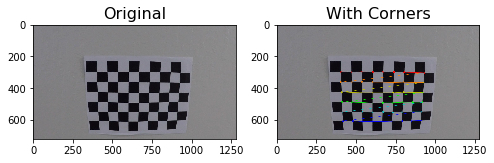

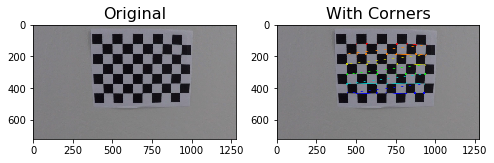

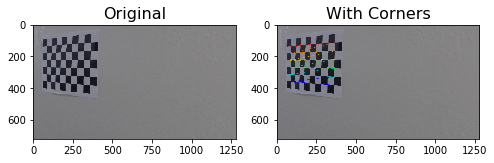

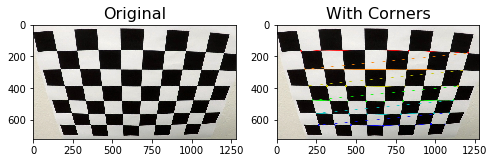

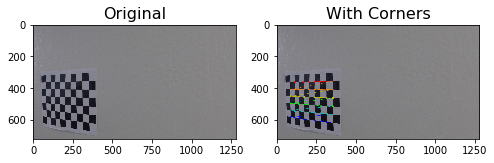

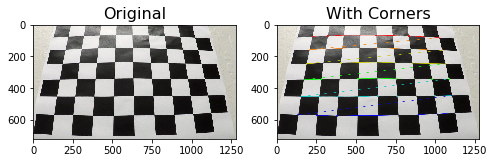

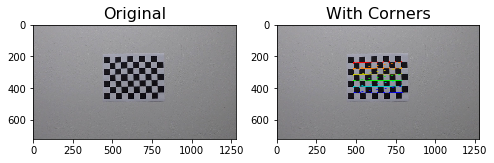

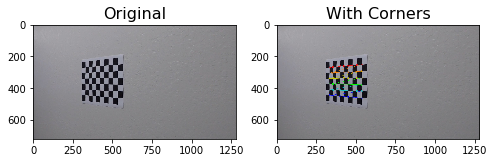

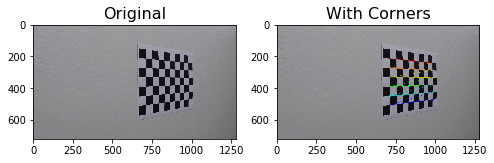

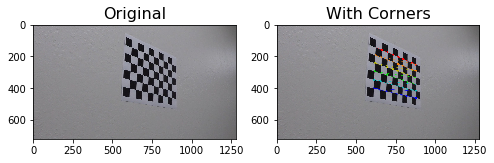

In [7]:
# Step through the list and search for chessboard corners
for fname in images:
    print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title("Original")
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title("With Corners")

In [13]:
# define a function to remove distortion from any image based on the objpoints, imgpoints and 
def undistort(image, show=True, read=True):
    if read:
        img = cv2.imread(image)
    img_size = (img.shape[1],img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image')
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image')
    else:
        return undist

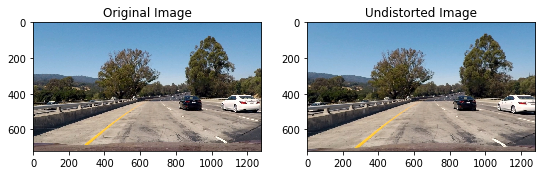

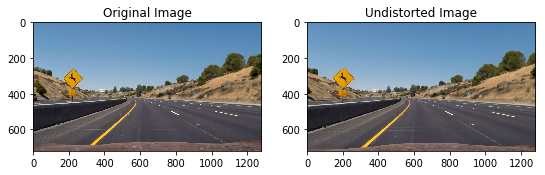

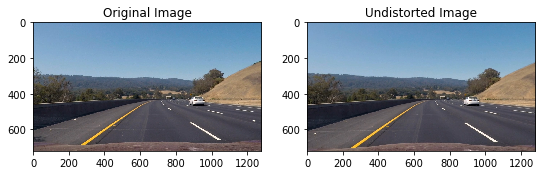

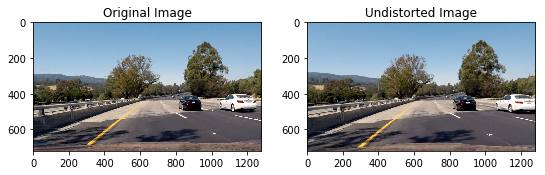

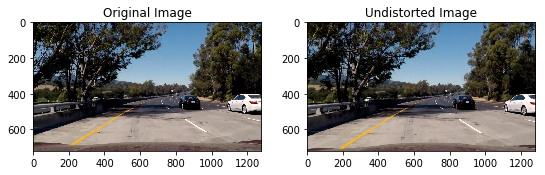

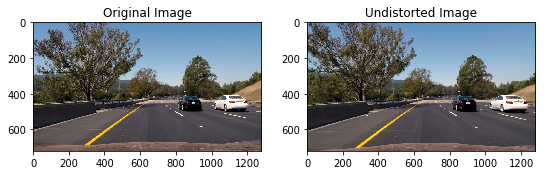

In [14]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    undistort(image)

## 2. Perspective Transform

In [49]:
# Apply perspective transform to show image from top
def warp(image, display=True, read=True):
    if read:
        undist = undistort(image, show=False)
    else:
        undist = undistort(image, show=False, read=False)
    img_size = (undist.shape[1],undist.shape[0])

    src = np.float32([[490, 480],[800, 480],[1180, 640],[170, 640]])
    dst = np.float32([[0,0],[1280,0],[1280,720],[0,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted')
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped')
    else:
        return warped, M

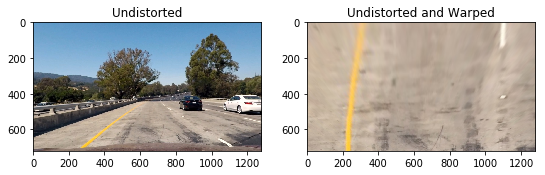

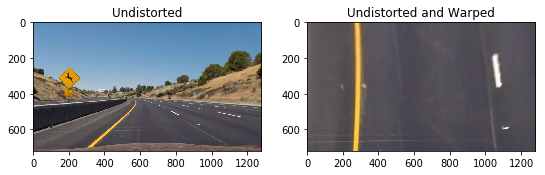

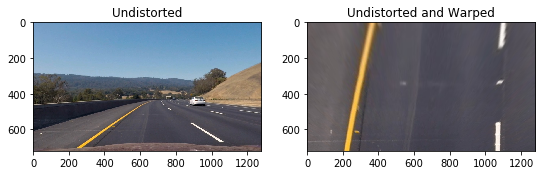

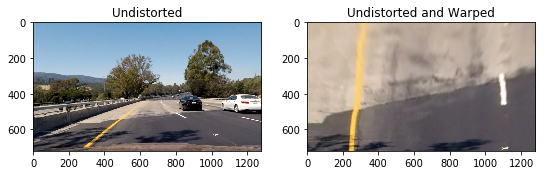

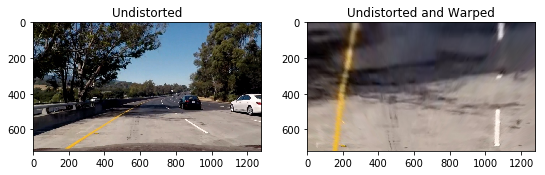

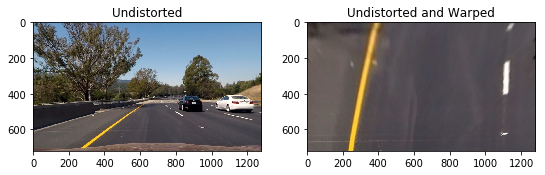

In [48]:
for image in glob.glob('test_images/test*.jpg'):
    warp(image)

## 3. Binary Thresholds

In [54]:
# Apply binary threshold to images to isolate lane line pixels
def threshold(image, show=True):
    img, M = warp(image, display=False)
    
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]
    
    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    if show:
        f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
        
        ax1.set_title('Original Undistorted Image')
        ax1.imshow(cv2.cvtColor(undistort(image, show=False), cv2.COLOR_BGR2RGB))
        
        ax2.set_title('Warped Image')
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax3.set_title('s binary threshold')
        ax3.imshow(s_binary, cmap='gray')
        
        ax5.set_title('l binary threshold')
        ax5.imshow(l_binary, cmap='gray')
        
        ax4.set_title('b binary threshold')
        ax4.imshow(b_binary, cmap='gray')

        ax6.set_title('Combined color thresholds')
        ax6.imshow(combined_binary, cmap='gray')
    
    else:
        return combined_binary

In [ ]:
for image in glob.glob('test_images/test*.jpg'):
    threshold(image)